# Fuzzy Label Generation

This notebook is for experimenting with the creation of "grayzone" labels and developing / testing / evaluating the fuzzy loss function.

## Preliminaries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import os

import numpy as np
import h5py

from functools import partial
from scipy import signal

import keras.backend as K
from keras import losses

## Read in existing labels

In [102]:
data_path = '/Users/timothy/Documents/Uni/01_Master/Masterarbeit/01_Code/' \
            'gw-continuous/src/data'

with h5py.File(os.path.join(data_path, 'training_samples.h5')) as file:

    # Only select the H1 labels for now
    labels = np.array([_[0] for _ in file['labels']]).astype('int')

## Calculate grayzones and plot labels

In [103]:
def make_grayzones(label):
    window = signal.hann(12)
    filtered = signal.convolve(label, win, mode='same') / sum(win)
    grayzone = np.fromiter(map(lambda x: 1-int(0 < x < 1), filtered), 
                           dtype=np.int)
    return grayzone

## Define a custom loss function

In [105]:
def fuzzy_binary_crossentropy(y_true, y_pred, weights=None):
    y_true = K.minimum(y_true, weights)
    y_pred = K.minimum(y_pred, weights)
    return losses.binary_crossentropy(y_true, y_pred)

## Generate faux predictions for testing

In [107]:
# Get two labels that are slightly off
labels_true = labels
labels_pred = []

for i in range(len(labels_true)):
    
    # Generate the mask for a random bitflip with probability 5%
    random_bits = np.random.uniform(low=0, high=1, size=labels_true.shape[1])
    bitflip_mask = np.fromiter(map(lambda x: int(x > 0.95), random_bits), 
                               dtype=np.int)
    
    # Perform bitflip on the current true label to create a dummy prediction
    label_pred = np.logical_xor(labels_true[i], bitflip_mask).astype('int')
    
    # Store away
    labels_pred.append(label_pred)

# Cast to numpy array
labels_pred = np.array(labels_pred)

## Evaluate the fuzzy loss on the faux predictions

In [114]:
# Evaluate the standard loss function
print('Standard Binary Cross-Entropy:')
standard_losses = K.eval(losses.binary_crossentropy(K.variable(labels_true), 
                                                    K.variable(labels_pred)))
print(np.mean(standard_losses), end='\n\n')

# Evaluate our fuzzy version of the loss function
weights = np.array([make_grayzones(_) for _ in labels_true])
curry = partial(fuzzy_binary_crossentropy, weights=K.variable(weights))
fuzzy_losses = K.eval(curry(K.variable(labels_true), K.variable(labels_pred)))
print('Custom Fuzzy Binary Cross-Entropy:')
print(np.mean(fuzzy_losses))

Standard Binary Cross-Entropy:
0.810203

Custom Fuzzy Binary Cross-Entropy:
0.741054


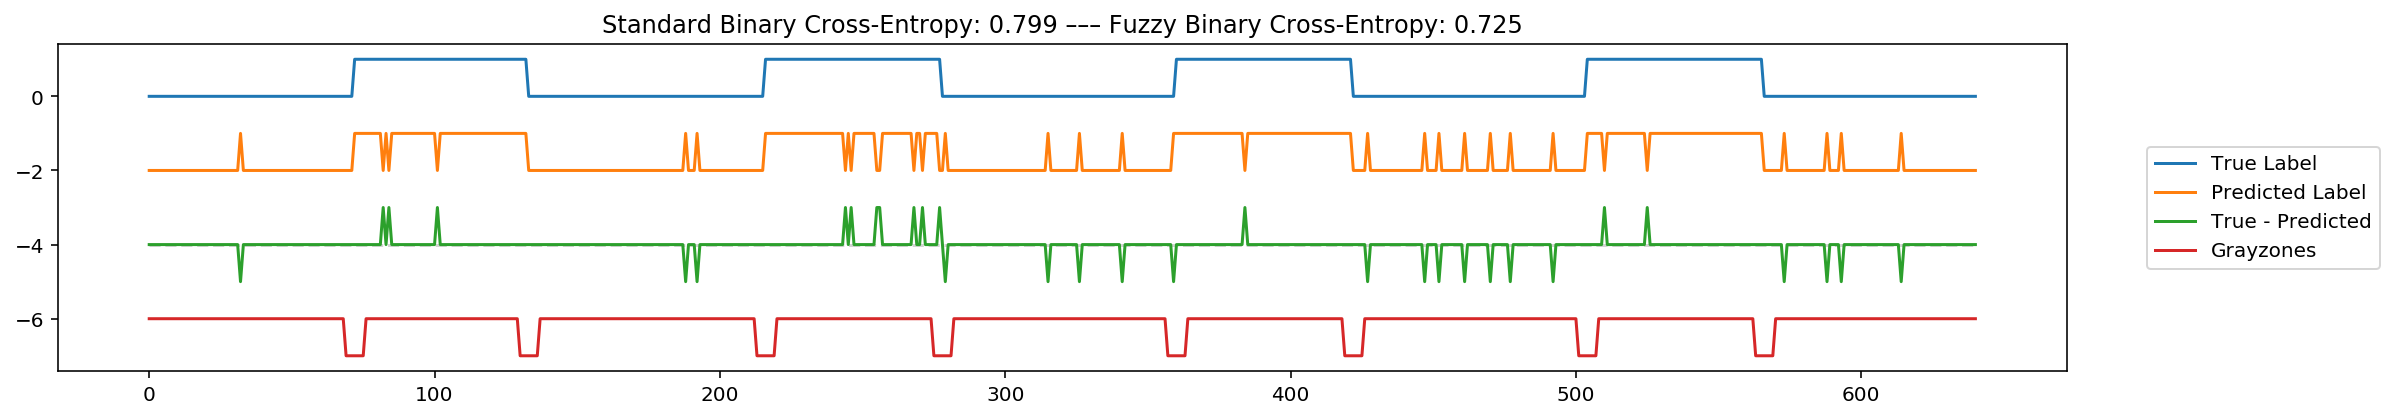

In [141]:
# Plot the labels
for i in range(1):
    
    # Plot true label, predicted label, differences, and grayzones
    plt.plot(labels_true[i], label="True Label")
    plt.plot(labels_pred[i]-2, label="Predicted Label")
    plt.plot([-4 for _ in range(len(labels_true[i]))], 
             ls='--', color='LightGray')
    plt.plot(labels_true[i]-labels_pred[i]-4, label="True - Predicted")
    plt.plot(weights[i]-7, label="Grayzones")
    
    # Calculate losses for this specific example and put them in the title
    standard_loss = losses.binary_crossentropy(K.variable(labels_true[i]), 
                                               K.variable(labels_pred[i]))
    curry = partial(fuzzy_binary_crossentropy, weights=K.variable(weights[i]))
    fuzzy_loss = curry(K.variable(labels_true[i]), K.variable(labels_pred[i]))
    plt.title('Standard Binary Cross-Entropy: {:.3f} ––– '
              'Fuzzy Binary Cross-Entropy: {:.3f}'.
              format(K.eval(standard_loss), K.eval(fuzzy_loss)))
    
    # Set up the legend and plot size
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    plt.gcf().set_size_inches(18, 3, forward=True)
    plt.show()